In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, HeatMap

In [73]:
df = pd.read_csv('Dados/Projecto 3_ Análise Espacial de Acidentes de Viação na Área Metropolitana de Maputo/dataset_acidentes.csv', encoding='latin1')
df.head(3)

,id,data,hora,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tracado_via,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude
0,262002,1/10/2020,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,0,1,0,1,0,1,2,-25.947978,32.565075
1,264173,1/21/2020,8:05:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,0,1,0,1,0,1,2,-25.964917,32.380069
2,270555,2/20/2020,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,0,1,0,1,0,1,2,-25.872439,32.610327


In [79]:
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1)
df.head(2)

,id,data,hora,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tracado_via,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,geometry
0,262002,1/10/2020,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,0,1,0,1,0,1,2,-25.947978,32.565075,POINT (32.56507534 -25.94797822)
1,264173,1/21/2020,8:05:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,0,1,0,1,0,1,2,-25.964917,32.380069,POINT (32.38006879 -25.96491672)


In [80]:
gdf = gpd.GeoDataFrame(df, geometry = 'geometry', crs = 'EPSG: 4326')
gdf.to_file('Dados/Projecto 3_ Análise Espacial de Acidentes de Viação na Área Metropolitana de Maputo/acidentes.geojson', driver = 'GeoJSON')

In [29]:
def carregar():
    # Importando o dataset de acidentes
    gdf = gpd.read_file('Dados/Projecto 3_ Análise Espacial de Acidentes de Viação na Área Metropolitana de Maputo/acidentes.geojson')
    gdf['data_hora'] = gdf['data'] + ' ' + gdf['hora']

    classe = gdf['classificacao_acidente'].unique()
    def classAcidentes(n):
        gdf_filtrado = gdf[gdf['classificacao_acidente'] == classe[n]]
        return gdf_filtrado
    
    gdf_semVitimas = classAcidentes(1)
    gdf_vitimasFeridas = classAcidentes(0)
    gdf_vitimasFatais = classAcidentes(2)
    return gdf, gdf_semVitimas, gdf_vitimasFeridas, gdf_vitimasFatais

gdf_acidentes, gdf_semVitimas, gdf_vitimasFeridas, gdf_vitimasFatais = carregar()

In [ ]:
# Coordenadas médias para centralizar o mapa na área de estudo
latMean = gdf_acidentes['latitude'].mean()
longMean = gdf_acidentes['longitude'].mean()

# Criação do mapa folium
map = folium.Map(location = [latMean, longMean], zoom_start = 10)

# Satélite
folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri World Imagery',
    name = 'Satellite',
    show = False,
    overlay = False,
    control = True
).add_to(map)

# Coordenadas dos pontos de acorrência dos acidentes
def coordenadas(gdf):
    data = gdf[['latitude', 'longitude']].dropna().values.tolist()
    return data

# Criação dos pontos por severidade
def points(gdf, name, cor):
    return folium.GeoJson(gdf,
                name = name,
                marker = folium.Circle(radius = 50,
                                        fill_color = cor, 
                                        fill_opacity = 0.4,
                                        color = 'black',
                                        weight = 0.1
                            ),
                tooltip = folium.GeoJsonTooltip(fields = ['causa_acidente',
                                                            'tipo_acidente',
                                                            'data_hora',
                                                            'fase_dia',
                                                            'condicao_metereologica',
                                                            'mortos',
                                                            'feridos_leves',
                                                            'feridos_graves',
                                                            'ilesos',
                                                            'veiculos'
                                                            ],
                                                aliases = ['Estado:',
                                                            'Tipo:',
                                                            'Data:',
                                                            'Fase do Dia:',
                                                            'Condição Metereológica:',
                                                            'Mortos:',
                                                            'Feridos Leves:',
                                                            'Feridos Graves:',
                                                            'Ilesos:',
                                                            'Veículos Involvidos:'
                                                            ],
                                                    style = """
                                                                background-color: #F0EFEF;
                                                                border: 1px solid black;
                                                                border-radius: 5px;
                                                                box-shadow: 3px;
                                                            """
                            )
                        
    ).add_to(map)

points(gdf_semVitimas, 'Sem Vítimas 🟢', 'green')
points(gdf_vitimasFeridas, 'Vítimas Feridas 🟠', 'orange')
points(gdf_vitimasFatais, 'Vítimas Fatais 🔴', 'red')

HeatMap(coordenadas(gdf_acidentes),
                    name = 'HeatMap',
                    show = False
).add_to(map)

folium.LayerControl().add_to(map)

map.save('mapa.html')


In [83]:
# Top 10 das causas de acidentes
causas = gdf_acidentes['causa_acidente'].value_counts().reset_index(name = 'Números de Acidentes')
causas.head(10)

,causa_acidente,Números de Acidentes
0,Falta de Atenção à Condução,22189
1,Velocidade Incompatível,7761
2,Desobediência às normas de trânsito pelo condutor,5588
3,Defeito Mecânico no Veículo,3933
4,Não guardar distância de segurança,3726
5,Ingestão de Álcool,3193
6,Pista Escorregadia,2751
7,Condutor Dormindo,2714
8,Falta de Atenção do Pedestre,1789
9,Animais na Pista,1019


In [82]:
tipo = gdf_acidentes['tipo_acidente'].value_counts().reset_index(name = 'Número de Acidentes')
tipo

,tipo_acidente,Número de Acidentes
0,Colisão traseira,11523
1,Saída de leito carroçável,8774
2,Colisão lateral,7062
3,Tombamento,6004
4,Colisão com objeto estático,5979
5,Colisão transversal,5429
6,Colisão frontal,3317
7,Queda de ocupante de veículo,3173
8,Atropelamento de Pedestre,3075
9,Capotamento,2484


In [139]:
gdf_acidentes.groupby('tipo_acidente')['mortos'].sum().sort_values(ascending = False).reset_index().head(3)

,tipo_acidente,mortos
0,Colisão frontal,1092
1,Atropelamento de Pedestre,821
2,Colisão traseira,455


In [4]:
gdf_acidentes.head(2)

,id,data,hora,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tracado_via,pessoas,...,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,geometry,data_hora
0,262002,1/10/2020,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,...,1,0,1,0,1,2,-25.947978,32.565075,POINT (32.56508 -25.94798),1/10/2020 21:40:00
1,264173,1/21/2020,8:05:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,...,1,0,1,0,1,2,-25.964917,32.380069,POINT (32.38007 -25.96492),1/21/2020 8:05:00


[Text(0, 0, '46,590'), Text(0, 0, '10,480'), Text(0, 0, '3,461')]

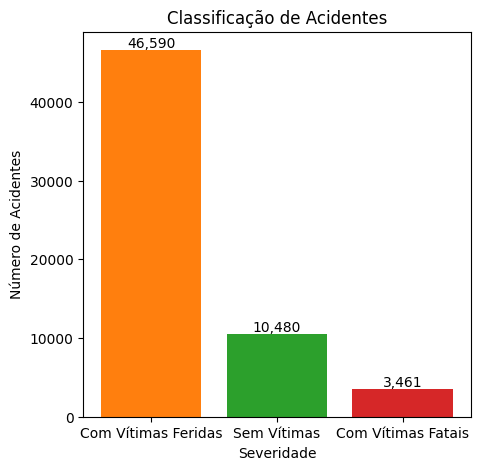

In [31]:
sev = gdf_acidentes['classificacao_acidente'].value_counts()
bar_labels = ['orange', 'green', 'red']
bar_colors = [ 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(figsize=(5, 5))

bar_container = ax.bar(sev.index.tolist(), sev.values.tolist(), label = bar_labels, color = bar_colors)
ax.set_ylabel('Número de Acidentes')
ax.set_xlabel('Severidade')
ax.set_title('Classificação de Acidentes')
ax.bar_label(bar_container, fmt='{:,.0f}')

In [30]:
gdf_acidentes['data'] = pd.to_datetime(gdf_acidentes['data'])

In [31]:
gdf_acidentes['mês'] = gdf_acidentes['data'].dt.month
gdf_acidentes['ano'] = gdf_acidentes['data'].dt.year
gdf_acidentes.head(3)

,id,data,hora,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tracado_via,pessoas,...,ilesos,ignorados,feridos,veiculos,latitude,longitude,geometry,data_hora,mês,ano
0,262002,2020-01-10,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,...,1,0,1,2,-25.947978,32.565075,POINT (32.56508 -25.94798),1/10/2020 21:40:00,1,2020
1,264173,2020-01-21,8:05:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,...,1,0,1,2,-25.964917,32.380069,POINT (32.38007 -25.96492),1/21/2020 8:05:00,1,2020
2,270555,2020-02-20,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,...,1,0,1,2,-25.872439,32.610327,POINT (32.61033 -25.87244),2/20/2020 21:40:00,2,2020


In [32]:
meses = {1: 'Janeiro', 
         2: 'Fevereiro', 
         3: 'Março', 
         4: 'Abril',
         5: 'Maio', 
         6: 'Junho', 
         7: 'Julho', 
         8: 'Agosto',
         9: 'Setembro', 
         10: 'Outubro', 
         11: 'Novembro', 
         12: 'Dezembro'
}

gdf_acidentes['mês'] = gdf_acidentes['mês'].map(meses)
gdf_acidentes.head(3)

,id,data,hora,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tracado_via,pessoas,...,ilesos,ignorados,feridos,veiculos,latitude,longitude,geometry,data_hora,mês,ano
0,262002,2020-01-10,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,...,1,0,1,2,-25.947978,32.565075,POINT (32.56508 -25.94798),1/10/2020 21:40:00,Janeiro,2020
1,264173,2020-01-21,8:05:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,...,1,0,1,2,-25.964917,32.380069,POINT (32.38007 -25.96492),1/21/2020 8:05:00,Janeiro,2020
2,270555,2020-02-20,21:40:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,...,1,0,1,2,-25.872439,32.610327,POINT (32.61033 -25.87244),2/20/2020 21:40:00,Fevereiro,2020


In [33]:
gdf_acidentes['mês'] = pd.Categorical(
    gdf_acidentes['mês'],
    categories = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro'],
    ordered=True
)

gdf_acidentes = gdf_acidentes.sort_values(['ano', 'mês'])
gdf_acidentes.head(3)

,id,data,hora,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tracado_via,pessoas,...,ilesos,ignorados,feridos,veiculos,latitude,longitude,geometry,data_hora,mês,ano
30,101177,2018-01-05,15:30:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,...,1,0,1,2,-25.778236,32.511350,POINT (32.51135 -25.77824),1/5/2018 15:30:00,Janeiro,2018
31,105969,2018-01-25,3:45:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,...,1,0,1,2,-25.777008,32.511227,POINT (32.51123 -25.77701),1/25/2018 3:45:00,Janeiro,2018
32,105996,2018-01-25,7:45:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,...,1,0,1,2,-25.871797,32.610795,POINT (32.61079 -25.8718),1/25/2018 7:45:00,Janeiro,2018


In [55]:
date = gdf_acidentes[['ano', 'mês']].groupby(['ano', 'mês']).size().reset_index(name = 'quant')
date.head(2)

C:\Users\user\AppData\Local\Temp\ipykernel_17388\261821671.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  date = gdf_acidentes[['ano', 'mês']].groupby(['ano', 'mês']).size().reset_index(name = 'quant')


,ano,mês,quant
0,2018,Janeiro,2247
1,2018,Fevereiro,1832


In [ ]:
date['ano_mês'] = date['ano'].astype(str) + '/' + date['mês'].astype(str)
date.head(3)

,ano,mês,quant,ano_mês
0,2018,Janeiro,2247,2018/Janeiro
1,2018,Fevereiro,1832,2018/Fevereiro
2,2018,Março,1983,2018/Março


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Janeiro'),
  Text(1, 0, 'Fevereiro'),
  Text(2, 0, 'Março'),
  Text(3, 0, 'Abril'),
  Text(4, 0, 'Maio'),
  Text(5, 0, 'Junho'),
  Text(6, 0, 'Julho'),
  Text(7, 0, 'Agosto'),
  Text(8, 0, 'Setembro'),
  Text(9, 0, 'Outubro'),
  Text(10, 0, 'Novembro'),
  Text(11, 0, 'Dezembro')])

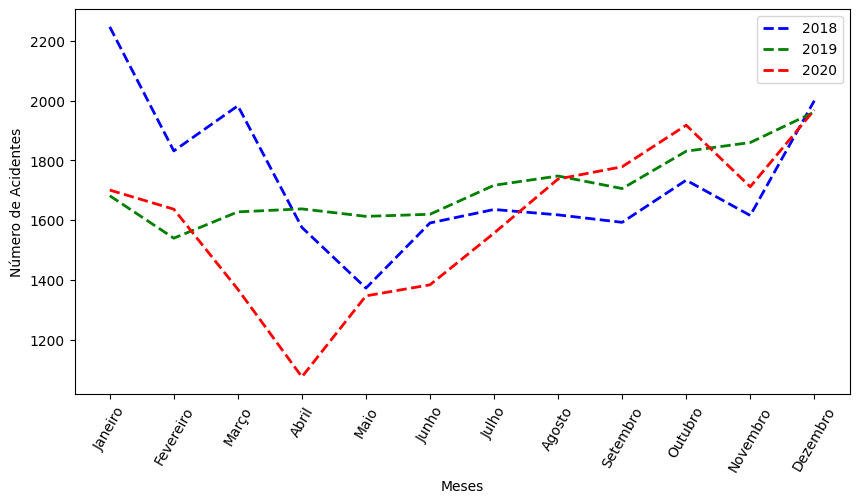

In [71]:
def dados(ano):
    return date[date['ano'] == ano]

fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(dados(2018)['mês'], dados(2018)['quant'], color = 'blue', linewidth = 2, linestyle = '--', label = '2018')

ax.plot(dados(2019)['mês'], dados(2019)['quant'], color = 'green', linewidth = 2, linestyle = '--', label = '2019')

ax.plot(dados(2020)['mês'], dados(2020)['quant'], color = 'red', linewidth = 2, linestyle = '--', label = '2020')

ax.legend()
ax.set_ylabel('Número de Acidentes')
ax.set_xlabel('Meses')
plt.xticks(rotation = 60)


In [88]:
gdf_acidentes['horas'] = pd.to_datetime(gdf_acidentes['hora']).dt.hour
gdf_acidentes.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_17388\1271953798.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdf_acidentes['horas'] = pd.to_datetime(gdf_acidentes['hora']).dt.hour


,id,data,hora,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tracado_via,pessoas,...,ignorados,feridos,veiculos,latitude,longitude,geometry,data_hora,mês,ano,horas
30,101177,2018-01-05,15:30:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,...,0,1,2,-25.778236,32.511350,POINT (32.51135 -25.77824),1/5/2018 15:30:00,Janeiro,2018,15
31,105969,2018-01-25,3:45:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Plena Noite,Céu Claro,Reta,2,...,0,1,2,-25.777008,32.511227,POINT (32.51123 -25.77701),1/25/2018 3:45:00,Janeiro,2018,3
32,105996,2018-01-25,7:45:00,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Céu Claro,Reta,2,...,0,1,2,-25.871797,32.610795,POINT (32.61079 -25.8718),1/25/2018 7:45:00,Janeiro,2018,7


In [132]:
horas = gdf_acidentes['horas'].value_counts().reset_index(name = 'Número de Acidentes').sort_values('horas')
horas['horas'] = horas['horas'].astype(str) + 'h'
horas.head()

,horas,Número de Acidentes
19,0h,1392
21,1h,1191
23,2h,1088
22,3h,1111
20,4h,1333


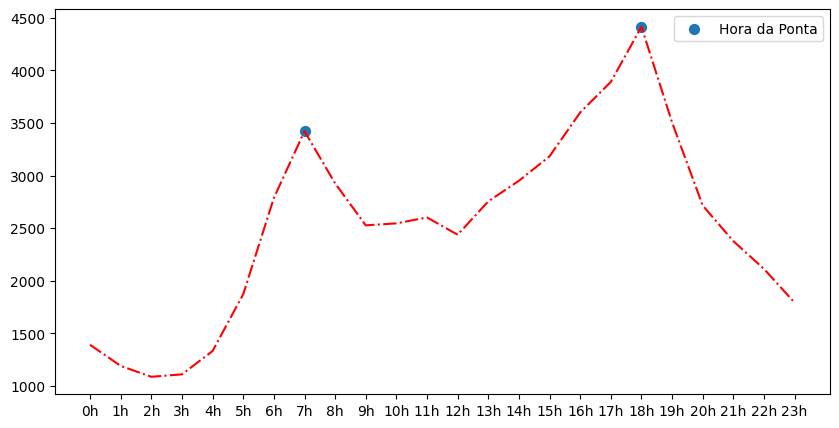

In [138]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(horas['horas'], horas['Número de Acidentes'], color = 'red', linestyle = '-.')

xoutliers = ['7h', '18h']
youtliers = [3422, 4414]
plt.scatter(xoutliers, youtliers, s = 50, label = 'Hora da Ponta')
plt.legend()